# Quality Control Workflow for Quotes

In this notebook, we demonstrate how users can create a workflow to upload quote data into LUSID. The workflow will then conduct a series of data quality checks on these quotes, raising any issues as exceptions for approval. This will help us to ensure the data we are upserting to LUSID is valid and suitable.

## Overview

We will be making use of the the Workflow Service which enables you to connect and control movement of data throughout LUSID, allowing you to model data and business operational controls. You can read more about the Workflow Service in the [Knowledge Base](https://support.lusid.com/knowledgebase/article/KA-02181/en-us).



For the purposes of this notebook, we will consider an example where an Excel file has been uploaded to LUSID Drive. This file contains quotes for various instruments. Our workflow will then work as follows:
1. The `ImportQuotes` task will be created and started.
2. A worker will be triggered to import quote data, from the given file in Drive, into LUSID.
3. A child task `ReasonableValueDataControl` will be created and started. This will trigger a worker flag values that are not between 1 and 1000.
4. A child task `IQROutlierDataControl` will be created and started. This will trigger a worker flag values that are not within the interquartile range of existing quotes for that instrument.
4. *TODO: deviations from the mean (e.g. 2.5SD)?, percentage checks from last quote?*
5. A child task `HandleException` will be created for each flagged value so a user can review any failures.

An overview of our workflow is below.

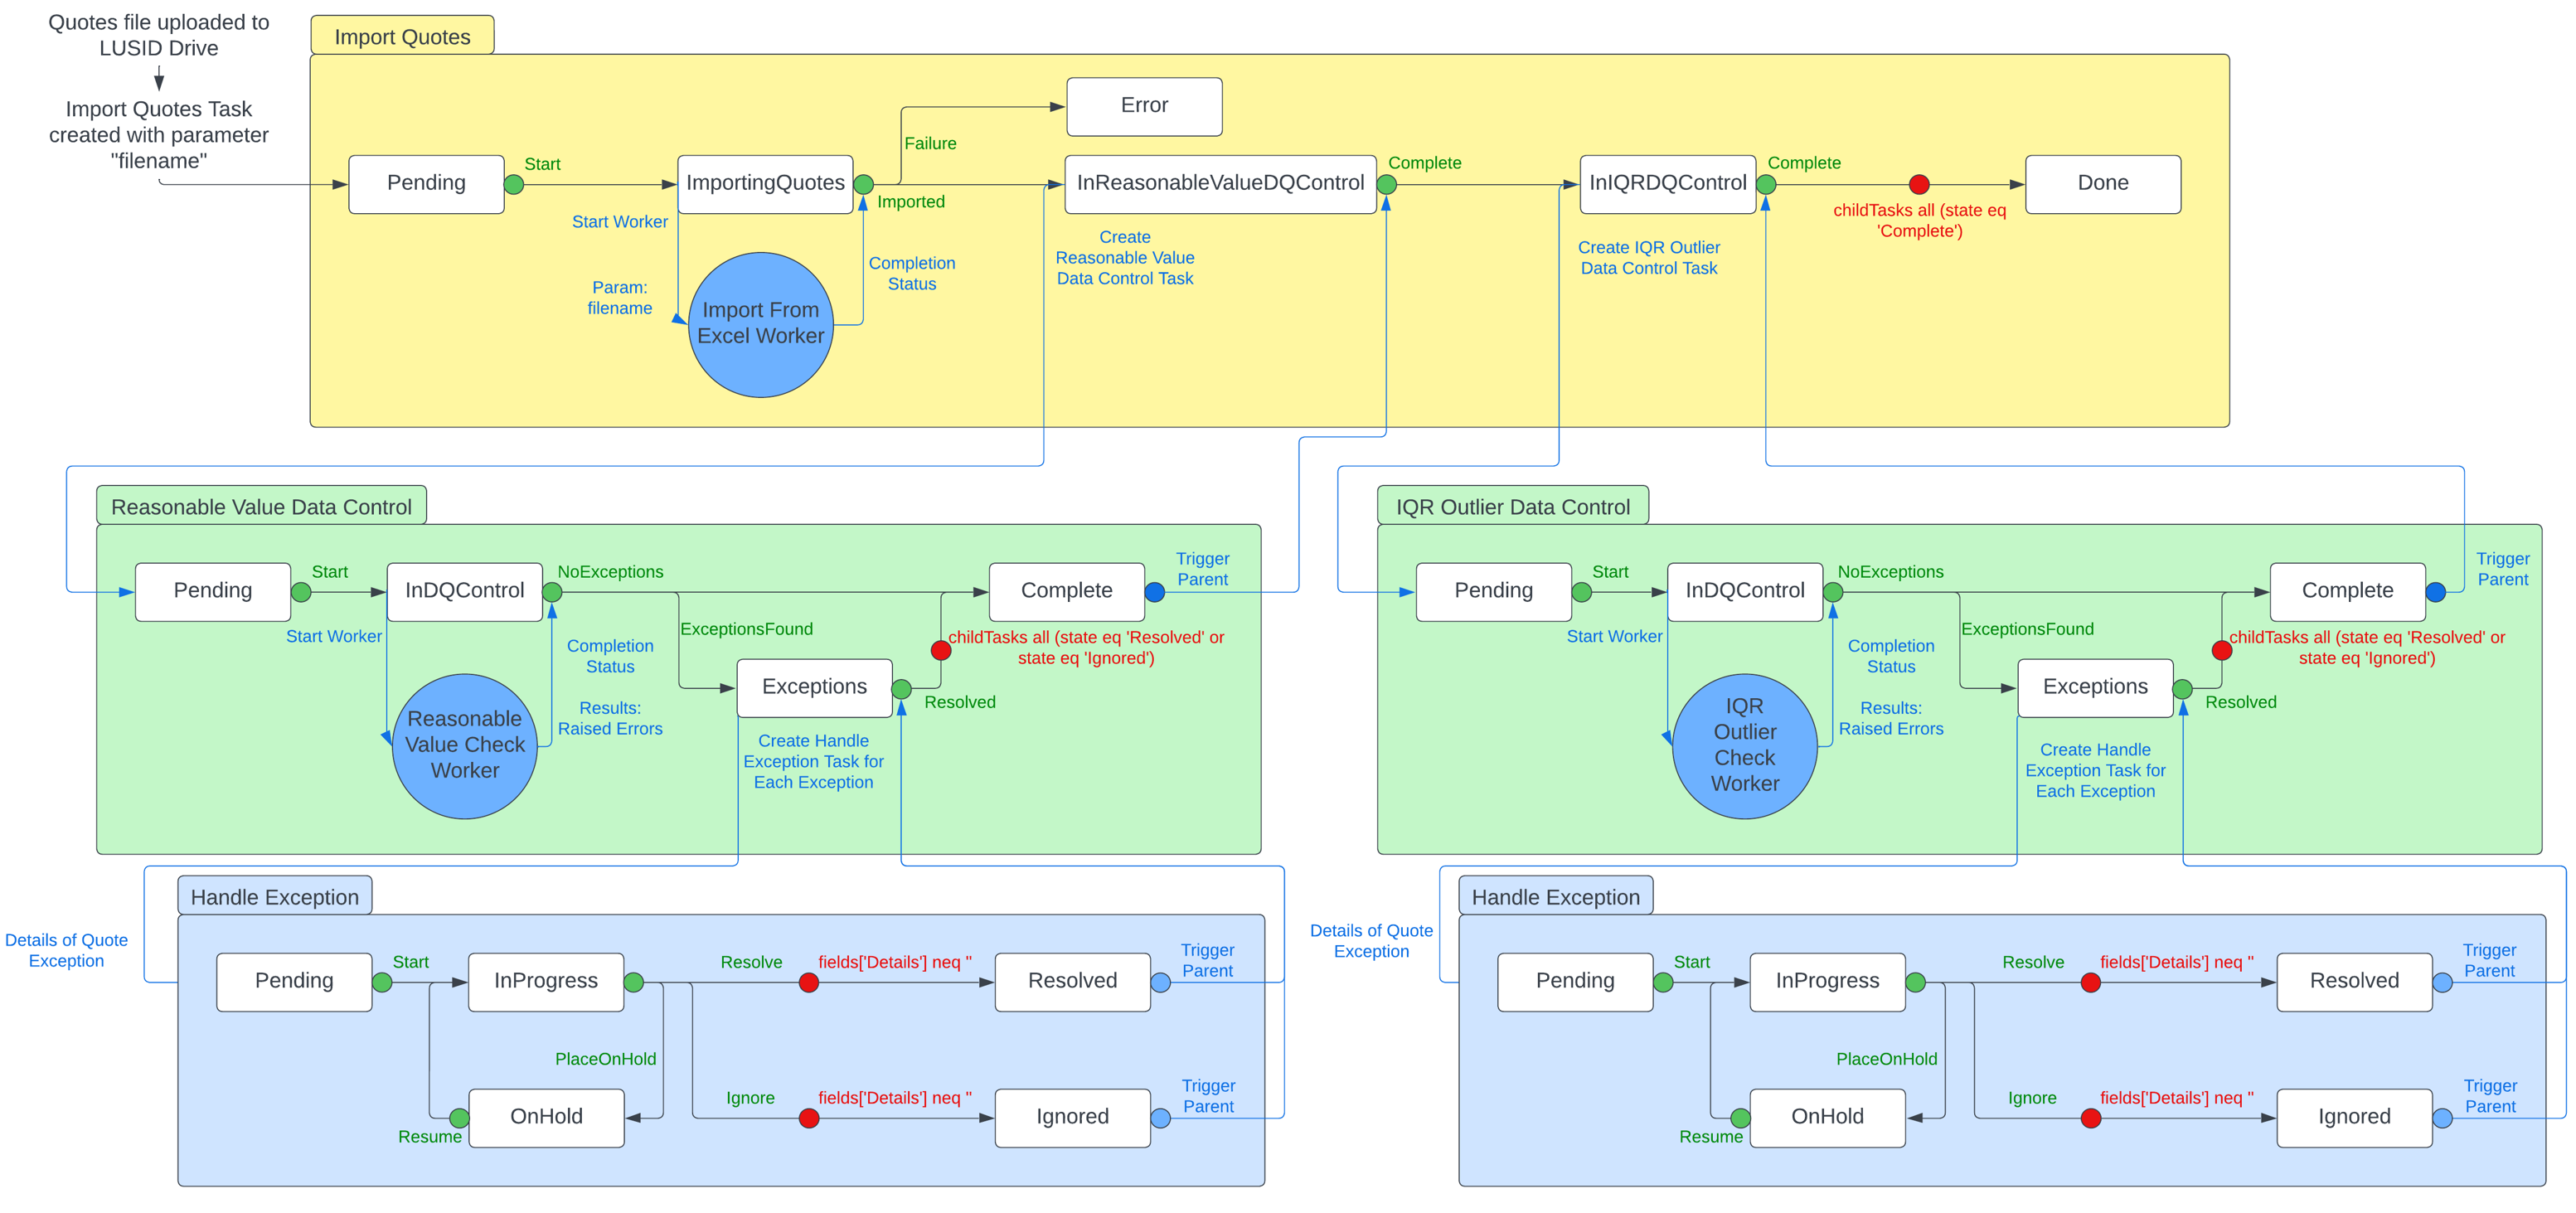

## Setup LUSID

We start by importing relevant libraries, authenticating our user, and creaing our API client.

In [1]:
# TODO: Remove line
!pip install -U lusid-workflow-sdk-preview

# Import general purpose packages
import sys
import time

# Import LUSID specific packages
from fbnsdkutilities import ApiClientFactory
import lusid_workflow
import lusid_workflow.models as wf_models
from lusid_workflow.rest import ApiException
from lusidjam.refreshing_token import RefreshingToken
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Authenticate out user and create our API client
# TODO: Have this work with fbnsdkutilities instead
configuration = lusid_workflow.Configuration(
    host="https://matthewfox.lusid.com/workflow"
)
configuration.access_token = RefreshingToken()

api_client = lusid_workflow.ApiClient(configuration)

In [2]:
# Define the relevant APIs we will use
task_def_api = lusid_workflow.TaskDefinitionsApi(api_client)
task_api = lusid_workflow.TasksApi(api_client)
worker_api = lusid_workflow.WorkersApi(api_client)

# Notebook constants
notebook_scope = 'quotes-workflow'

## 1. Prepare Luminesce Views & Workers

In our workflow, we will be making use of workers. A worker makes use if Luminesce Views to input parameters mapped from the fields of a task, and return results which can be mapped to a task definition.

### 1.1. Import Quotes from File

We can use Luminesce to create a custom view which takes in a parameter of a filename to extract quotes from to load into LUSID.

In [3]:
%%luminesce


-- Create view and set parameters
@import_quotes_view = use Sys.Admin.SetupView
    --provider=Custom.Quotes.ImportFromCSV
    --parameters
        filename,Text,/quotes/exampledata.xlsx,false
----

@@filename = select #PARAMETERVALUE(filename);


-- Load data from csv
@inst_data = use Drive.Excel with @@filename
    --file={@@filename}
    --worksheet=instrument
enduse;

@quote_data = use Drive.Excel with @@filename
    --file={@@filename}
    --worksheet=price_time_series
enduse;


-- Create instruments if not Active
@equity_instruments =
    select inst_id as ClientInternal, name as DisplayName, ccy as DomCcy
    from @inst_data;

select *
from Lusid.Instrument.Equity.Writer
where ToWrite = @equity_instruments;


-- Transform quote data
@quotes_for_upload =
    select
        'ClientInternal' as InstrumentIdType,
        instrument_id as InstrumentId,
        'quotes-workflow' as QuoteScope,
        'Price' as QuoteType,
        'Lusid' as Provider,
        'Mid' as Field,
        price_date as QuoteEffectiveAt,
        price as Value,
        ccy as Unit
    from @quote_data;


-- Upload quotes into LUSID
select *
from Lusid.Instrument.Quote.Writer
where ToWrite = @quotes_for_upload;

enduse;

select * from Custom.Quotes.ImportFromCSV
where filename='/quotes/exampledata.xlsx';

,WriteAsAt,WriteErrorCode,WriteError,WriteErrorDetail,WriteAction,LusidInstrumentId,Isin,Sedol,Cusip,Ticker,...,State,AsAtCreated,UserIdCreated,RequestIdCreated,AsAtModified,UserIdModified,RequestIdModified,AsAtVersionNumber,Identifiers,DomCcy
0,2023-10-23 13:56:00.443,0,NaN,NaN,Upsert,LUID_00003DCU,NaN,NaN,NaN,NaN,...,Active,2023-10-23 13:56:00.443,00uh5cp6tdahVrHMY2p7,e919601c-01ca-4f51-8d8f-e9be25b344ff,2023-10-23 14:05:52.280,00uh5cp6tdahVrHMY2p7,5193fa49-d81e-4965-94a0-6d6f0beef7d1,4,NaN,USD
1,2023-10-23 13:56:00.443,0,NaN,NaN,Upsert,LUID_00003DCT,NaN,NaN,NaN,NaN,...,Active,2023-10-23 13:56:00.443,00uh5cp6tdahVrHMY2p7,e919601c-01ca-4f51-8d8f-e9be25b344ff,2023-10-23 14:05:52.280,00uh5cp6tdahVrHMY2p7,5193fa49-d81e-4965-94a0-6d6f0beef7d1,4,NaN,GBP
2,2023-10-23 14:05:52.105,0,NaN,NaN,Upsert,LUID_00003DCW,NaN,NaN,NaN,NaN,...,Active,2023-10-23 14:05:52.105,00uh5cp6tdahVrHMY2p7,5193fa49-d81e-4965-94a0-6d6f0beef7d1,2023-10-23 14:05:52.105,00uh5cp6tdahVrHMY2p7,5193fa49-d81e-4965-94a0-6d6f0beef7d1,1,NaN,USD


We then create a worker to wrap the functionality in `Custom.Quotes.ImportFromExcel` into our workflow.

In [4]:
import_from_excel_worker_request = wf_models.CreateWorkerRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="ImportFromExcel"),
    display_name="Import From Excel",
    description="Imports quote data from specified Excel file in Drive.",
    worker_configuration=wf_models.LuminesceView(
        type="LuminesceView", name="Custom.Quotes.ImportFromCSV"
    ),
)

try:
    response = worker_api.create_worker(
        create_worker_request=import_from_excel_worker_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Worker already exists.")
    else:
        raise e


Worker already exists.


### 1.2. Data Quality Check for Reasonable Values 

Similarly, we can configure workers to conduct various data quality checks. For example, we will create a worker to ensure a quote's price is a sensible value (between 1 and 1000, say). As before, we will create a custom view that checks all quotes in our scope.

In [5]:
%%luminesce

-- Create view and set parameters
@iqr_outlier_view = use Sys.Admin.SetupView
--provider=Custom.PriceCheck.ReasonableValue
----

-- Collect quotes for all instruments
@quotes_data = select *
    from Lusid.Instrument.Quote
    where QuoteScope = 'quotes-workflow'
        and InstrumentIdType = 'ClientInternal'
        and QuoteType = 'Price';

-- Collect instrument static
@instrument_data = select
    ClientInternal,
    DisplayName
    from Lusid.Instrument.Equity
    where State = 'Active';

-- Generate time series
@price_ts = select
    ClientInternal,
    DisplayName,
    QuoteEffectiveAt as [PriceDate],
    Unit as [Currency],
    Value as [Price]
    from @instrument_data i
    join @quotes_data q on (i.ClientInternal = q.InstrumentId);

-- Run reasonable value check for each quote
select
    PriceDate,
    ClientInternal,
    DisplayName,
    Price,
    case 
        when Price >= 1000 then 'Unreasonably Large Value'
        when Price <= 1 then 'Unreasonably Small Value'
        else 'OK'
    end as Result
    from @price_ts
    where not Result = 'OK';

enduse;

select * from Custom.PriceCheck.ReasonableValue

,PriceDate,ClientInternal,DisplayName,Price,Result
0,2022-07-25,EQ56JD720LSU,Tesco Plc,1005,Unreasonably Large Value
1,2022-04-21,EQ56JD720345,Visa Inc,1,Unreasonably Small Value


As before, we create a worker to wrap the functionality in `Custom.PriceCheck.ReasonableValue` into our workflow.

In [6]:
reasonable_value_worker_request = wf_models.CreateWorkerRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="ReasonableValueChecker"),
    display_name="Reasonable Value Checker",
    description="Find any quotes with values not between 1 and 1000.",
    worker_configuration=wf_models.LuminesceView(
        type="LuminesceView", name="Custom.PriceCheck.ReasonableValue"
    )
)

try:
    response = worker_api.create_worker(
        create_worker_request=reasonable_value_worker_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Worker already exists.")
    else:
        raise e

Worker already exists.


### 1.3. Data Quality Checks for Interquartile Range (IQR) Outliers

Another example of a data quality check we may want to conduct, is finding any outliers for a given instrument with the $1.5\times \texttt{IQR}$ rule. That is, to find any quotes that fall between $\texttt{Q}1 - 1.5\times \texttt{IQR}$ or above $\texttt{Q}3 + 1.5\times \texttt{IQR}$. As before, we will create a custom view that checks all quotes in our scope.

In [7]:
%%luminesce


-- Create view and set parameters
@iqr_outlier_view = use Sys.Admin.SetupView
--provider=Custom.PriceCheck.OnePointFiveIQR
----
    
-- Collect quotes for all instruments
@quotes_data = select *
    from Lusid.Instrument.Quote
    where QuoteScope = 'quotes-workflow'
        and InstrumentIdType = 'ClientInternal'
        and QuoteType = 'Price';
        
-- Collect instrument static
@instrument_data = select
    ClientInternal,
    DisplayName
    from Lusid.Instrument.Equity
    where State = 'Active';
    
-- Generate time series
@price_ts = select
    ClientInternal,
    DisplayName,
    QuoteEffectiveAt as [PriceDate],
    Unit as [Currency],
    Value as [Price]
    from @instrument_data i
    join @quotes_data q on (i.ClientInternal = q.InstrumentId);
    
-- Run IQR checks for each instrument
@iqr_data = select
    ClientInternal,
    interquartile_range(price) * (1.5) as [iqr_x1_5],
    quantile(price, 0.25) as [q1],
    quantile(price, 0.75) as [q3]
    from @price_ts
    group by ClientInternal;
    
-- Join the IQR data with the time series and identify outliers
select
    p.PriceDate,
    p.ClientInternal,
    p.DisplayName,
    i.q1,
    i.q3,
    (i.q3 + i.iqr_x1_5) as [UpperLimit],
    (i.q1 - i.iqr_x1_5) as [LowerLimit],
    p.Price,
    case when p.Price not between (i.q1 - i.iqr_x1_5) and (i.q3 + i.iqr_x1_5)
        then 'IQR Outlier'
        else 'OK'
    end as Result
    from @price_ts p
    join @iqr_data i on p.ClientInternal = i.ClientInternal
    where not Result = 'OK';

enduse;

select * from Custom.PriceCheck.OnePointFiveIQR

,PriceDate,ClientInternal,DisplayName,q1,q3,UpperLimit,LowerLimit,Price,Result
0,2022-01-23,EQ56JD720MDJ,Pay Pal Holdings Inc,94,105,121.5,77.5,150,IQR Outlier
1,2022-02-20,EQ56JD720MDJ,Pay Pal Holdings Inc,94,105,121.5,77.5,40,IQR Outlier
2,2022-01-08,EQ56JD720LSU,Tesco Plc,280,362,485.0,157.0,98,IQR Outlier
3,2022-02-20,EQ56JD720LSU,Tesco Plc,280,362,485.0,157.0,900,IQR Outlier
4,2022-02-21,EQ56JD720LSU,Tesco Plc,280,362,485.0,157.0,800,IQR Outlier
5,2022-07-25,EQ56JD720LSU,Tesco Plc,280,362,485.0,157.0,1005,IQR Outlier
6,2022-04-14,EQ56JD720345,Visa Inc,61,89,131.0,19.0,5,IQR Outlier
7,2022-04-21,EQ56JD720345,Visa Inc,61,89,131.0,19.0,1,IQR Outlier
8,2022-05-26,EQ56JD720345,Visa Inc,61,89,131.0,19.0,509,IQR Outlier


As before, we create a worker to wrap the functionality in `Custom.PriceCheck.OnePointFiveIQR` into our workflow.

In [8]:
iqr_outliers_worker_request = wf_models.CreateWorkerRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="IQROutliers"),
    display_name="IQR Outliers",
    description="Find any IQR outlier quotes.",
    worker_configuration=wf_models.LuminesceView(
        type="LuminesceView", name="Custom.PriceCheck.OnePointFiveIQR"
    )
)

try:
    response = worker_api.create_worker(
        create_worker_request=iqr_outliers_worker_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Worker already exists.")
    else:
        raise e

Worker already exists.


## 2. Task Definitions

Now that we have our workers setup, we will define the Task Definitions that will govern our workflow. Looking at our example, we have four different Task Definitions that make up our workflow: **Import Quotes**, **Reasonable Value DQ**, **IQR Outlier DQ**, and **Handle Exception**. We will analyse and define each in reverse order.

### 2.1. Handle Exception
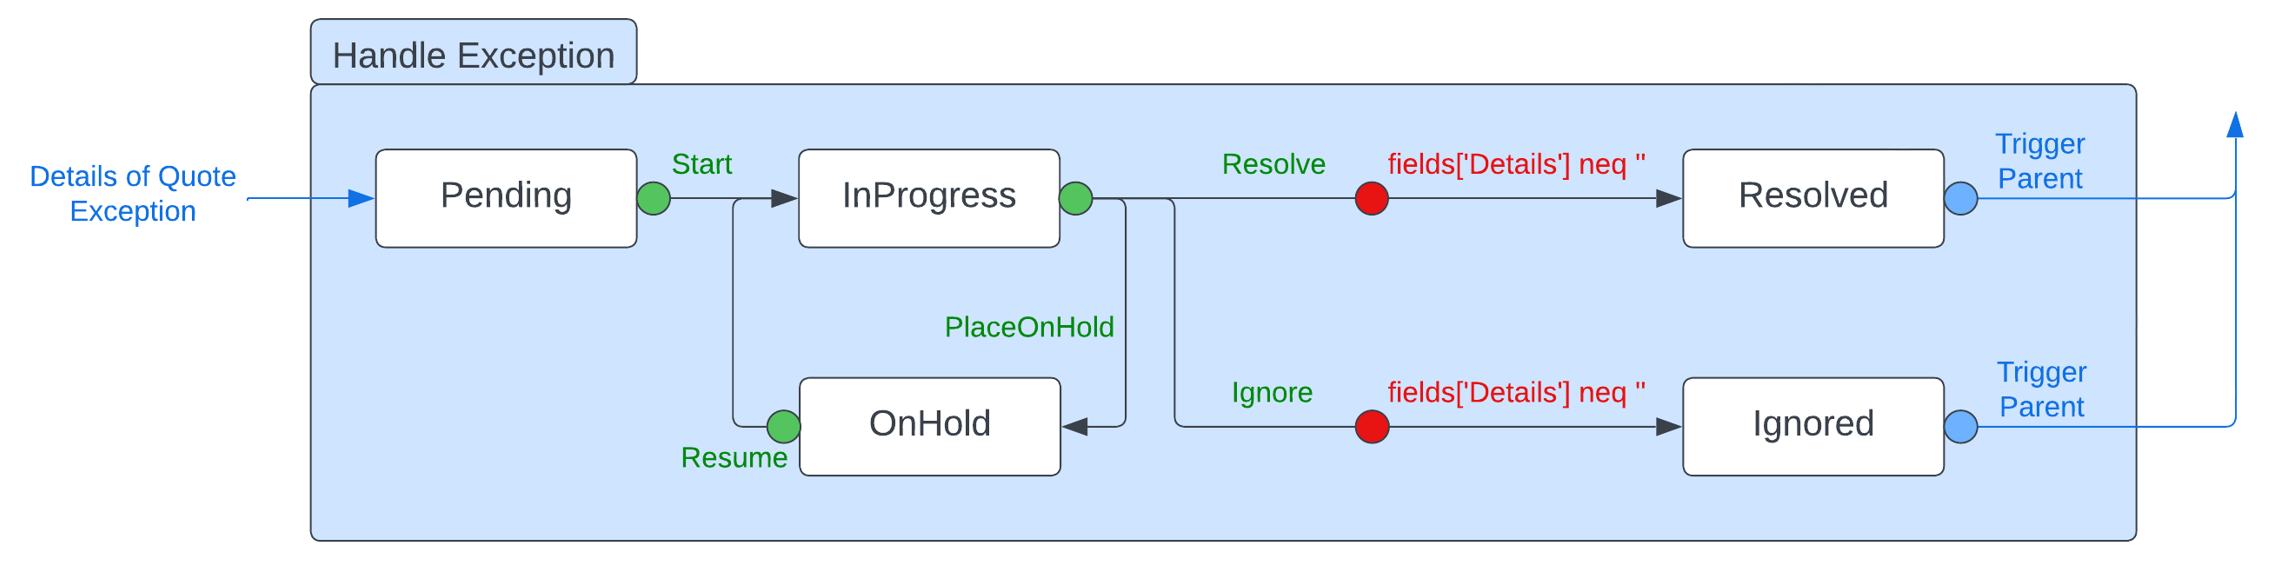

Our first task definition, `HandleException`, takes details of individual quotes that have failed a DQ check. This will effectievely forms a queue of potentially erroneous data for review by a user.

Details of the quote exception is passed and the task is started with the `Start` trigger. When in the `InProgress` state, a user can choose to place the exception on hold, resolve the exception, or mark the exception as ignored. To resolve or ignore the exception, the user must supply an explanation in the `Details` field; this is ensured with the use of Guards. In either case, the relevant trigger is passed to the parent.

*TODO: Should a user be able to manually correct the data here? I guess this is the main goal here*

In [9]:
handle_exception_task_definition_request = wf_models.CreateTaskDefinitionRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="HandleException"),
    display_name="Handle Exception",
    description="Handle any data outliers that are raised.",
    
    # Define the states of the workflow
    states=[
        wf_models.TaskStateDefinition(name="Pending"),
        wf_models.TaskStateDefinition(name="InProgress"),
        wf_models.TaskStateDefinition(name="Resolved"),
        wf_models.TaskStateDefinition(name="OnHold"),
        wf_models.TaskStateDefinition(name="Ignored")
    ],
    
    # Define the input parameters
    field_schema=[
        wf_models.TaskFieldDefinition(name="PriceDate", type="DateTime"),
        wf_models.TaskFieldDefinition(name="ClientInternal", type="String"),
        wf_models.TaskFieldDefinition(name="DisplayName", type="String"),
        wf_models.TaskFieldDefinition(name="Price", type="Decimal"),
        wf_models.TaskFieldDefinition(name="Result", type="String"),
        wf_models.TaskFieldDefinition(name="Details", type="String")
    ],
    
    # Define the default state a task should enter and the required parameters it should pass
    initial_state=wf_models.InitialState(name="Pending", required_fields=[
        "PriceDate", "ClientInternal", "DisplayName", "Price", "Result"
    ]),
    
    # Define the triggers which cause state transitions
    triggers=[
        wf_models.TransitionTriggerDefinition(name="Start", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Resolve", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="PlaceOnHold", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Resume", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Ignore", trigger=wf_models.TriggerSchema(type="External"))
    ],
    
    # Define the state transitions including the states the task should move from and to, the trigger causing it to occur,
    # any guard conditions required to be met, and any actions that should be taken upon completion.
    transitions=[
        wf_models.TaskTransitionDefinition(
            from_state="Pending",
            to_state="InProgress",
            trigger="Start"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InProgress",
            to_state="Resolved",
            trigger="Resolve",
            guard="fields['Details'] neq ''",
            action="resolved-trigger-parent"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InProgress",
            to_state="OnHold",
            trigger="PlaceOnHold",
        ),
        wf_models.TaskTransitionDefinition(
            from_state="OnHold",
            to_state="InProgress",
            trigger="Resume"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InProgress",
            to_state="Ignored",
            trigger="Ignore",
            guard="fields['Details'] neq ''",
            action="resolved-trigger-parent"
        )
    ],
    actions=[
        wf_models.ActionDefinition(
            name="resolved-trigger-parent",
            action_details=wf_models.TriggerParentTaskAction(
                type="TriggerParentTask",
                trigger="Resolved"
            )
        )
    ]
)


try:
    response = task_def_api.create_task_definition(
        create_task_definition_request=handle_exception_task_definition_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Task Definition already exists.")
    else:
        raise e

Task Definition already exists.


### 2.2. Reasonable Value Data Control
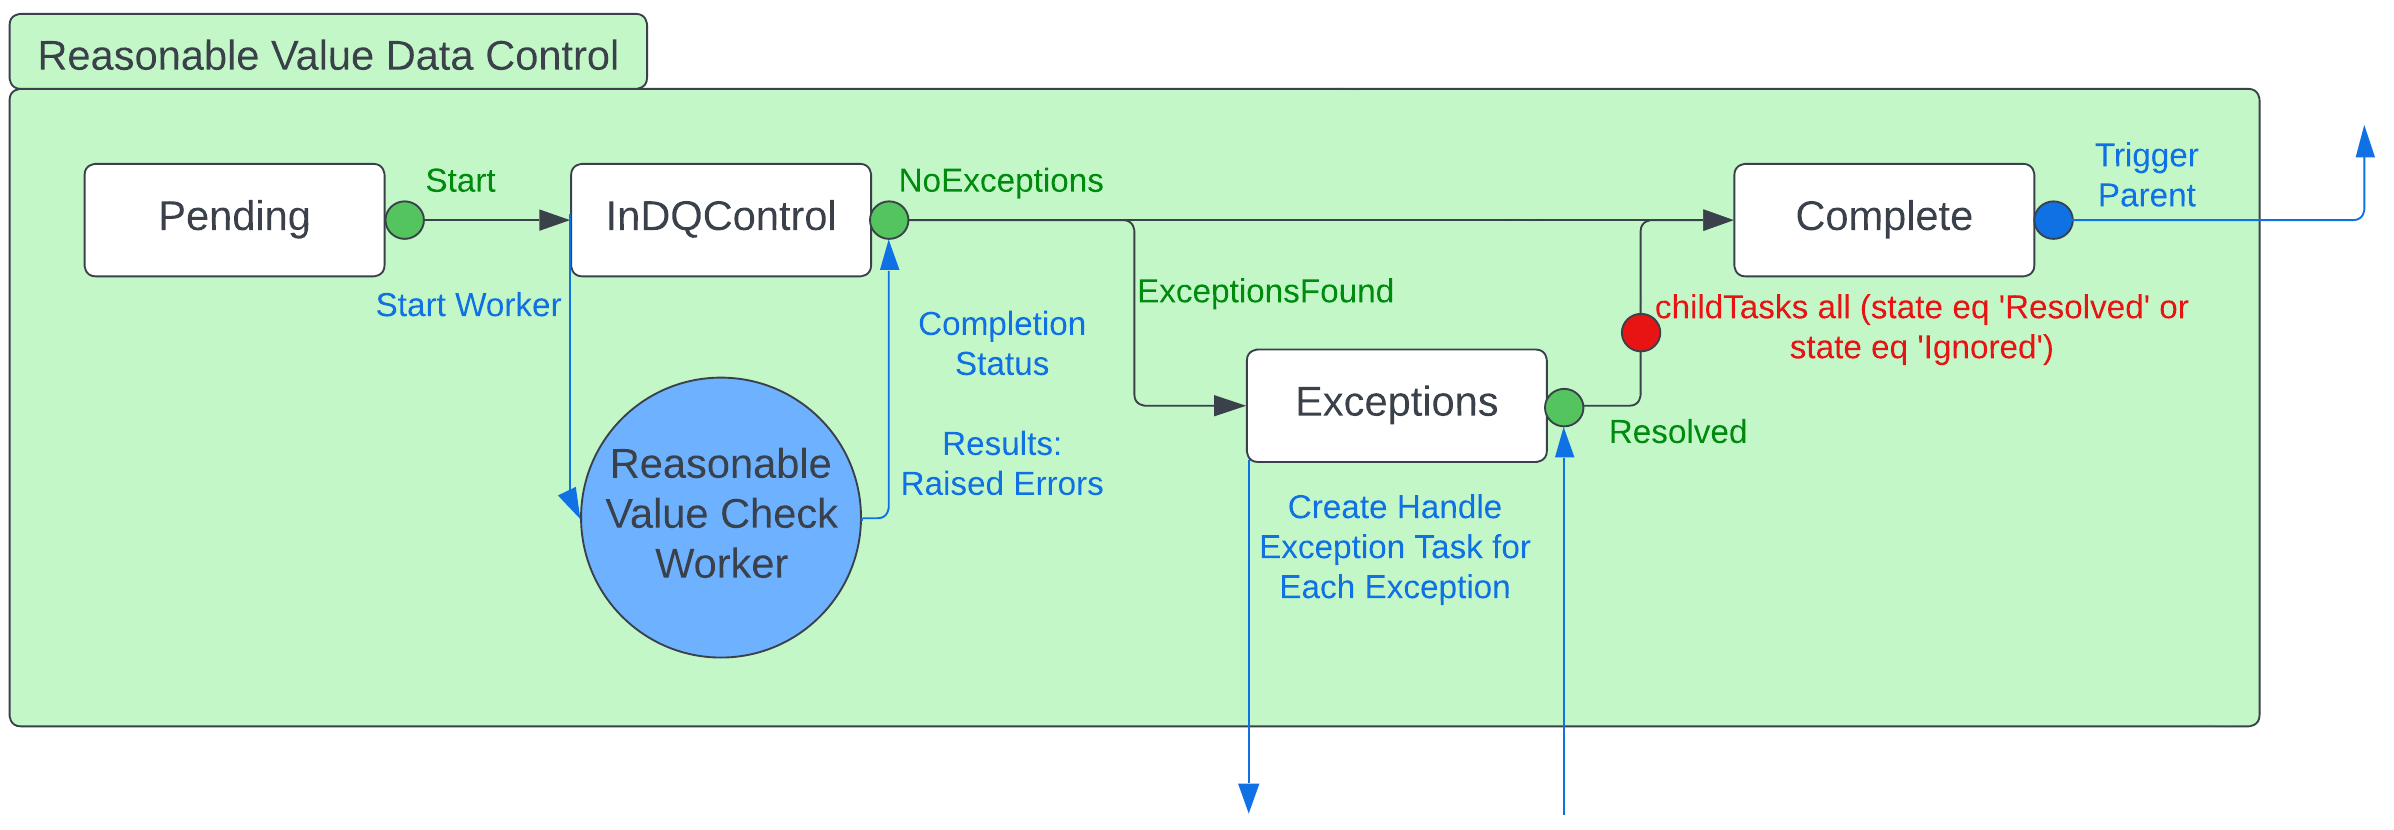

Our second task definition, `ReasonableValueDataControl`, is started by our main/parent workflow and checks all quotes in the given scope has a sensible value (between 1 and 1000). Any potentially erroneous data creates a `HandleException` Task, defined above, for review by a user.

The task is started with the `Start` trigger by the parent workflow. When in the `InDQControl` state, a Worker is started which checks that all quote values within the scope are within the specified range. If there are no exceptions then the Task moves to the `Complete` state, however, if exceptions are found then a `HandleException` Task is created for each one, as defined above. Upon completion of handling all examples, the state will pass to `Complete` state, only when all child tasks are resolved, governed by a Guard. In either case, a trigger is passed to the parent Task so it can progress.

In [10]:
reasonable_value_control_task_definition_request = wf_models.CreateTaskDefinitionRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="ReasonableValueDataControl"),
    display_name="Reasonable Value Data Control",
    description="Conduct reasonable value data control on quote data. Raise any exceptions.",
    states=[
        wf_models.TaskStateDefinition(name="Pending"),
        wf_models.TaskStateDefinition(name="InDQControl"),
        wf_models.TaskStateDefinition(name="Exceptions"),
        wf_models.TaskStateDefinition(name="Complete")
    ],
    initial_state=wf_models.InitialState(name="Pending"),
    triggers=[
        wf_models.TransitionTriggerDefinition(name="Start", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="NoExceptions", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="ExceptionsFound", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Resolved", trigger=wf_models.TriggerSchema(type="External"))
    ],
    transitions=[
        wf_models.TaskTransitionDefinition(
            from_state="Pending",
            to_state="InDQControl",
            trigger="Start",
            action="start-reasonable-value-worker"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InDQControl",
            to_state="Complete",
            trigger="NoExceptions",
            action="complete-trigger-parent"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InDQControl",
            to_state="Exceptions",
            trigger="ExceptionsFound"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="Exceptions",
            to_state="Complete",
            trigger="Resolved",
            guard="childTasks all (state eq 'Resolved' or state eq 'Ignored')",
            action="complete-trigger-parent"
        )
    ],
    actions=[
        wf_models.ActionDefinition(
            name="start-reasonable-value-worker",
            action_details=wf_models.RunWorkerAction(
                type="RunWorker",
                worker_id=wf_models.ResourceId(scope=notebook_scope, code="ReasonableValueChecker"),
                worker_status_triggers=wf_models.WorkerStatusTriggers(
                    completed_with_results="ExceptionsFound",
                    completed_no_results="NoExceptions",
                ),
                child_task_configurations=[wf_models.ResultantChildTaskConfiguration(
                    task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="HandleException"),
                    initial_trigger="Start",
                    child_task_fields={
                        "PriceDate": wf_models.FieldMapping(map_from="PriceDate"),
                        "ClientInternal": wf_models.FieldMapping(map_from="ClientInternal"),
                        "DisplayName": wf_models.FieldMapping(map_from="DisplayName"),
                        "Price": wf_models.FieldMapping(map_from="Price"),
                        "Result": wf_models.FieldMapping(map_from="Result"),
                    }
                )]
            )
        ),
        wf_models.ActionDefinition(
            name="complete-trigger-parent",
            action_details=wf_models.TriggerParentTaskAction(
                type="TriggerParentTask",
                trigger="Complete"
            )
        )
    ]
)
try:
    response = task_def_api.create_task_definition(
        create_task_definition_request=reasonable_value_control_task_definition_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Task Definition already exists.")
    else:
        raise e

Task Definition already exists.


### 2.3. Interquartile Range (IQR) Outlier Data Control
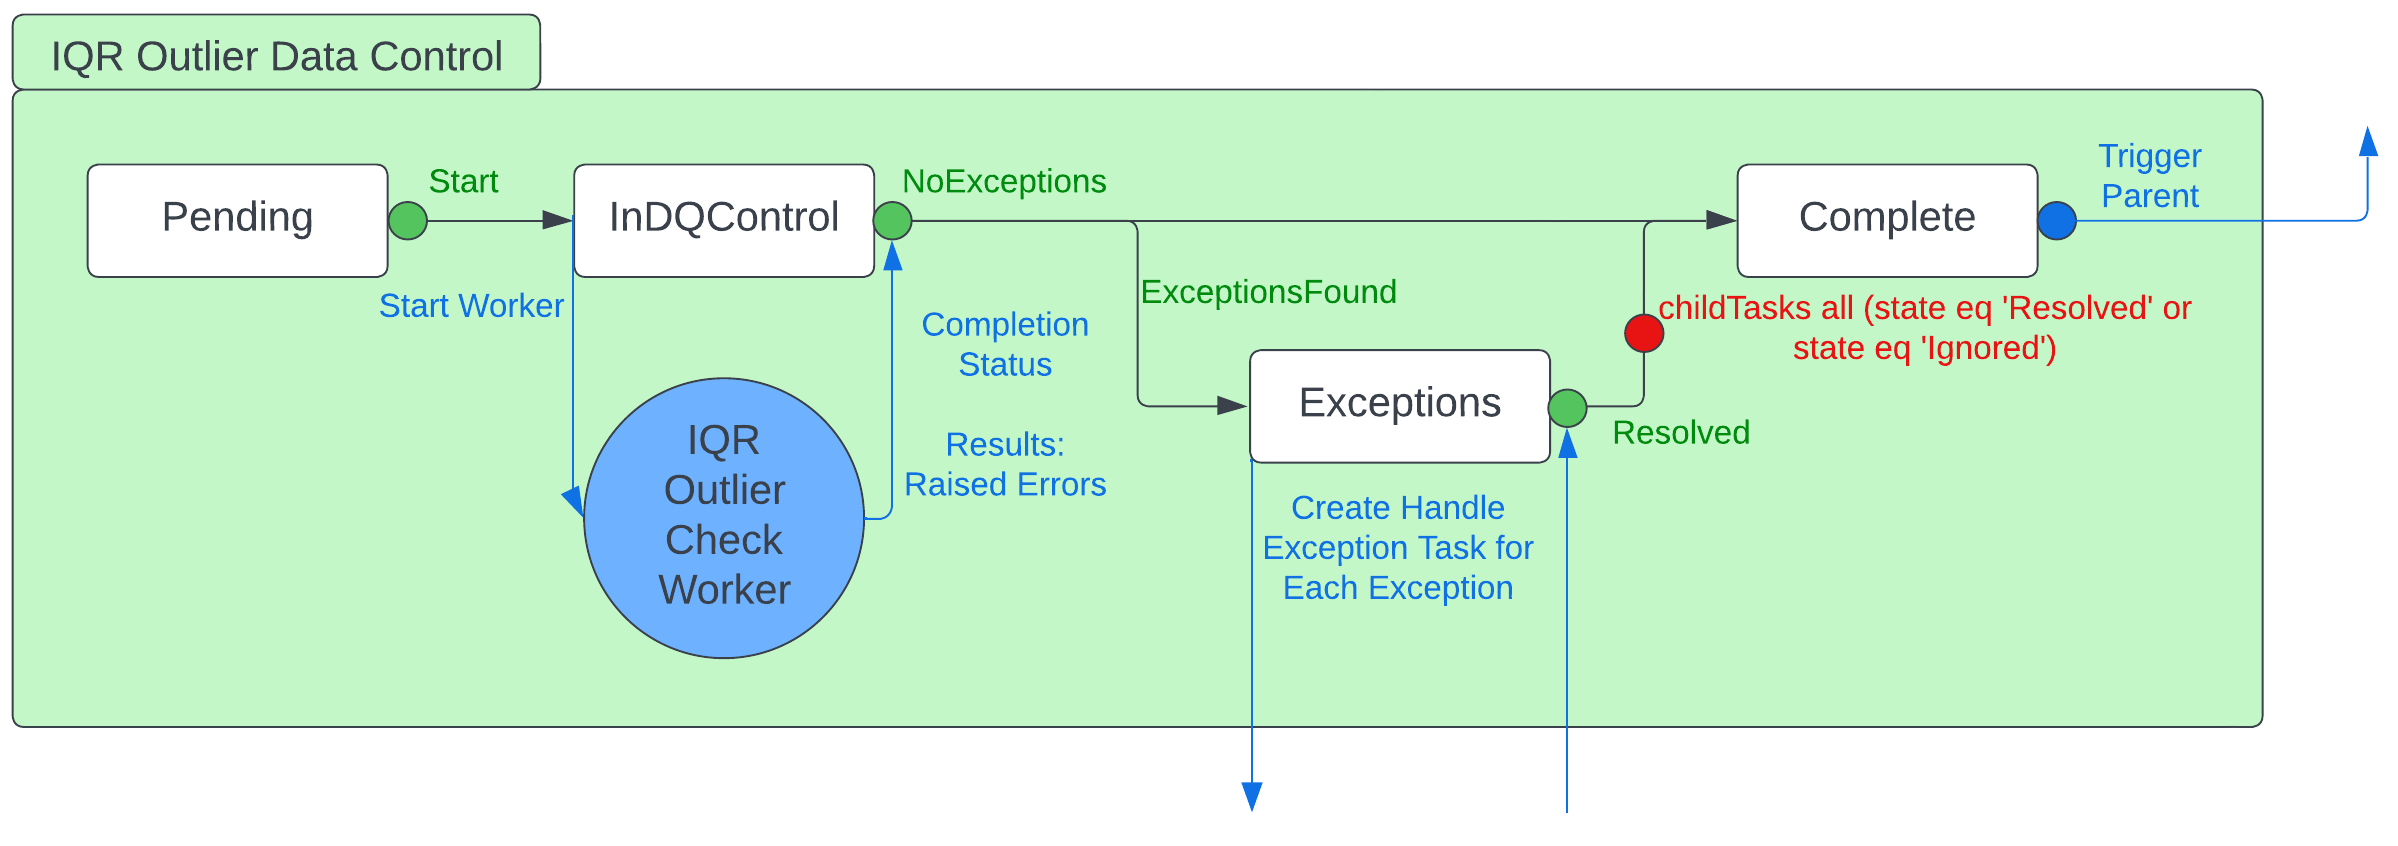

Our next task definition, `IQROutlierDataControl`, is again started by our main/parent workflow and checks all quotes in the given scope meet the $1.5\times \texttt{IQR}$ rule for each given instrument. This task operates in the same way as defined in our previous task definition; any potentially erroneous data creates a `HandleException` Task. The main difference in definition is the use of another previously defined Workers.

In [11]:
iqr_outlier_control_task_definition_request = wf_models.CreateTaskDefinitionRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="IQROutlierDataControl"),
    display_name="IQR Outlier Data Control",
    description="Conduct IQR outlier data control on quote data. Raise any exceptions.",
    states=[
        wf_models.TaskStateDefinition(name="Pending"),
        wf_models.TaskStateDefinition(name="InDQControl"),
        wf_models.TaskStateDefinition(name="Exceptions"),
        wf_models.TaskStateDefinition(name="Complete")
    ],
    initial_state=wf_models.InitialState(name="Pending"),
    triggers=[
        wf_models.TransitionTriggerDefinition(name="Start", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="NoExceptions", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="ExceptionsFound", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Resolved", trigger=wf_models.TriggerSchema(type="External"))
    ],
    transitions=[
        wf_models.TaskTransitionDefinition(
            from_state="Pending",
            to_state="InDQControl",
            trigger="Start",
            action="start-iqr-outlier-worker"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InDQControl",
            to_state="Complete",
            trigger="NoExceptions",
            action="complete-trigger-parent"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InDQControl",
            to_state="Exceptions",
            trigger="ExceptionsFound"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="Exceptions",
            to_state="Complete",
            trigger="Resolved",
            guard="childTasks all (state eq 'Resolved' or state eq 'Ignored')",
            action="complete-trigger-parent"
        )
    ],
    actions=[
        wf_models.ActionDefinition(
            name="start-iqr-outlier-worker",
            action_details=wf_models.RunWorkerAction(
                type="RunWorker",
                worker_id=wf_models.ResourceId(scope=notebook_scope, code="IQROutliers"),
                worker_status_triggers=wf_models.WorkerStatusTriggers(
                    completed_with_results="ExceptionsFound",
                    completed_no_results="NoExceptions",
                ),
                child_task_configurations=[wf_models.ResultantChildTaskConfiguration(
                    task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="HandleException"),
                    initial_trigger="Start",
                    child_task_fields={
                        "PriceDate": wf_models.FieldMapping(map_from="PriceDate"),
                        "ClientInternal": wf_models.FieldMapping(map_from="ClientInternal"),
                        "DisplayName": wf_models.FieldMapping(map_from="DisplayName"),
                        "Price": wf_models.FieldMapping(map_from="Price"),
                        "Result": wf_models.FieldMapping(map_from="Result"),
                    }
                )]
            )
        ),
        wf_models.ActionDefinition(
            name="complete-trigger-parent",
            action_details=wf_models.TriggerParentTaskAction(
                type="TriggerParentTask",
                trigger="Complete"
            )
        )
    ]
)
try:
    response = task_def_api.create_task_definition(
        create_task_definition_request=iqr_outlier_control_task_definition_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Task Definition already exists.")
    else:
        raise e

Task Definition already exists.


### 2.4. (Main/Parent) Import Quotes

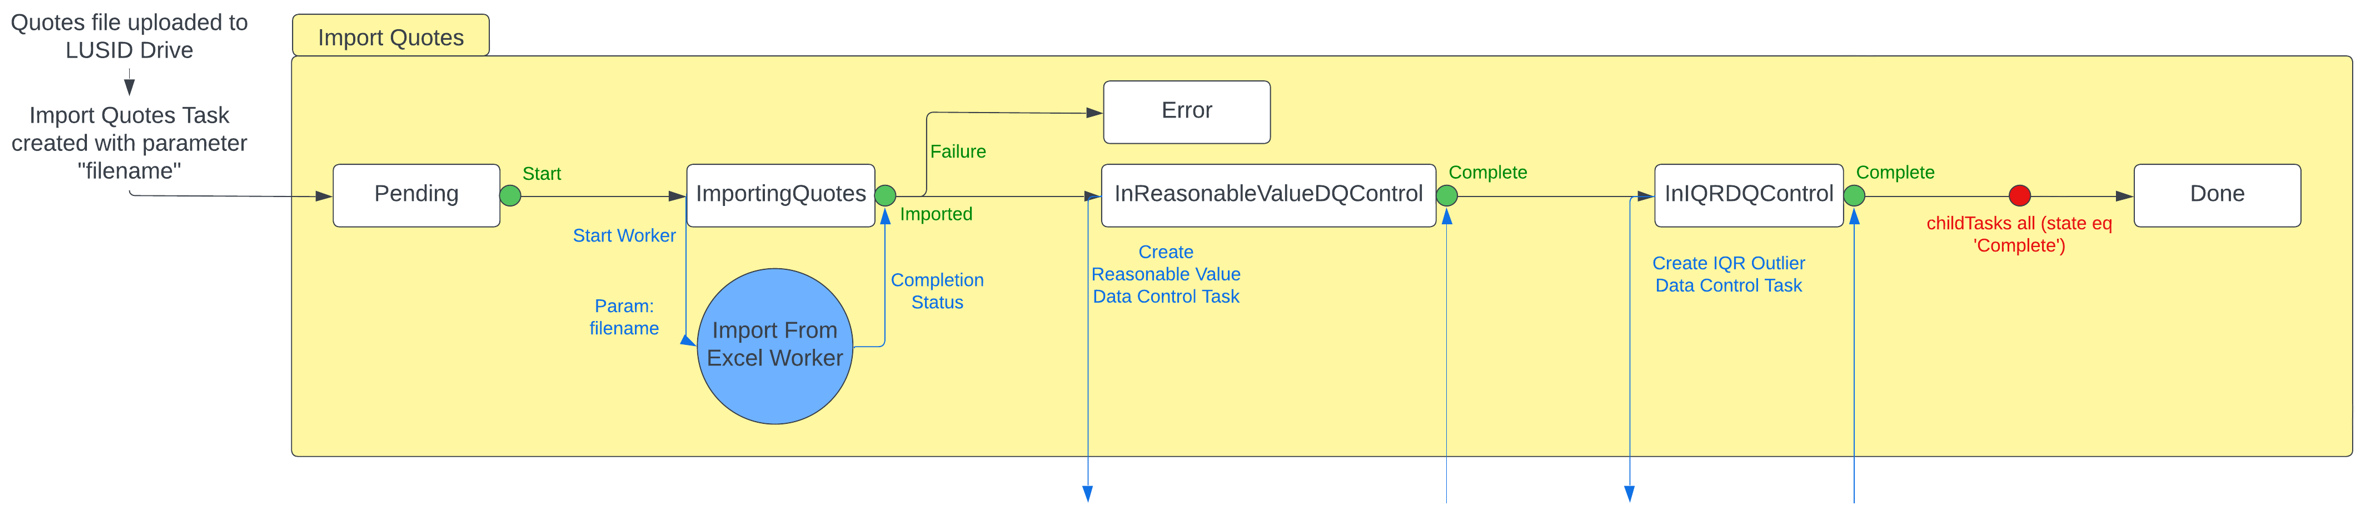

Piecing everything together, we now define our parent `ImportQuotes` Task Definition. This is will import our quote data, and start our data quality control checks.

First, a user would upload an Excel file into LUSID Drive. They can then start the task by using the `Start` Trigger and passing the parameter `fieldname`, the file path of the uploaded Excel file. This starts the `ImportFromExcel` file which loads the relevant instrument and quote data into LUSID. Then two child Tasks are created sequentially, `ReasonableValueDataControl` and `IQROutlierDataControl`, to check for unreasonable values and IQR outliers, respctively. As discussed above, any exceptions found will create `HandleException` Tasks to be managed by the user.

In [12]:
import_quotes_task_definition_request = wf_models.CreateTaskDefinitionRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="ImportQuotes"),
    display_name="Import Quotes",
    description="Import and validate quote data from specified Excel file.",
    states=[
        wf_models.TaskStateDefinition(name="Pending"),
        wf_models.TaskStateDefinition(name="ImportingQuotes"),
        wf_models.TaskStateDefinition(name="InReasonableValueDQControl"),
        wf_models.TaskStateDefinition(name="InIQROutlierDQControl"),
        wf_models.TaskStateDefinition(name="Done"),
        wf_models.TaskStateDefinition(name="Error")
    ],
    field_schema=[
        wf_models.TaskFieldDefinition(name="filename", type="String")
    ],
    initial_state=wf_models.InitialState(name="Pending", required_fields=["filename"]),
    triggers=[
        wf_models.TransitionTriggerDefinition(name="Start", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Failure", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Imported", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Complete", trigger=wf_models.TriggerSchema(type="External"))
    ],
    transitions=[
        wf_models.TaskTransitionDefinition(
            from_state="Pending",
            to_state="ImportingQuotes",
            trigger="Start",
            action="start-import-worker"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="ImportingQuotes",
            to_state="InReasonableValueDQControl",
            trigger="Imported",
            action="create-reasonable-value-task"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InReasonableValueDQControl",
            to_state="InIQROutlierDQControl",
            trigger="Complete",
            action="create-IQR-outlier-task"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="ImportingQuotes",
            to_state="Error",
            trigger="Failure"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InIQROutlierDQControl",
            to_state="Done",
            trigger="Complete",
            guard="childTasks all (state eq 'Complete')"
        )
    ],
    actions=[
        wf_models.ActionDefinition(
            name="start-import-worker",
            action_details=wf_models.RunWorkerAction(
                type="RunWorker",
                worker_id=wf_models.ResourceId(scope=notebook_scope, code="ImportFromExcel"),
                worker_parameters={
                    "filename": wf_models.FieldMapping(map_from="filename")
                },
                worker_status_triggers=wf_models.WorkerStatusTriggers(
                    started="Start",
                    completed_with_results="Imported",
                    completed_no_results="Failure",
                    failed_to_complete="Failure",
                    failed_to_start="Failure",
                ),
                
            )
        ),
        wf_models.ActionDefinition(
            name="create-reasonable-value-task",
            action_details=wf_models.CreateChildTasksAction(
                type="CreateChildTasks",
                child_task_configurations=[wf_models.CreateChildTaskConfiguration(
                    task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="ReasonableValueDataControl"),
                    initial_trigger="Start"
                )]
            )
        ),
        wf_models.ActionDefinition(
            name="create-IQR-outlier-task",
            action_details=wf_models.CreateChildTasksAction(
                type="CreateChildTasks",
                child_task_configurations=[wf_models.CreateChildTaskConfiguration(
                    task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="IQROutlierDataControl"),
                    initial_trigger="Start"
                )]
            )
        )
    ]
)
# print(import_quotes_task_definition_request)
try:
    response = task_def_api.create_task_definition(
        create_task_definition_request=import_quotes_task_definition_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Task Definition already exists.")
    else:
        raise e

Task Definition already exists.


## Create Example Tasks

In [13]:
task_api.create_task(
    trigger="Start",
    create_task_request=wf_models.CreateTaskRequest(
        task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="ImportQuotes"),
        fields=[
            wf_models.TaskInstanceField(name="filename", value="/quotes/exampledata.xlsx")
        ]
    )
)

{'as_at_last_transition': datetime.datetime(2023, 11, 6, 16, 44, 43, 921049, tzinfo=tzlocal()),
 'child_tasks': [],
 'correlation_ids': [],
 'fields': [{'name': 'filename', 'value': '/quotes/exampledata.xlsx'}],
 'id': 'a75f84fd-dbde-4867-a513-d6c457fe5034',
 'parent_task': None,
 'state': 'ImportingQuotes',
 'task_definition_display_name': 'Import Quotes',
 'task_definition_id': {'code': 'ImportQuotes', 'scope': 'quotes-workflow'},
 'task_definition_version': {'as_at_modified': datetime.datetime(2023, 11, 3, 15, 41, 30, 275977, tzinfo=tzlocal())},
 'terminal_state': False,
 'ultimate_parent_task': {'id': 'a75f84fd-dbde-4867-a513-d6c457fe5034',
                          'state': 'ImportingQuotes',
                          'task_definition_display_name': 'Import Quotes',
                          'task_definition_id': {'code': 'ImportQuotes',
                                                 'scope': 'quotes-workflow'},
                          'task_definition_version': {'as_at_modifi

In [14]:
task_api.list_tasks()

{'href': 'https://matthewfox.lusid.com/workflow/api/tasks/?asAt=2023-11-06T16%3A44%3A43.9210490%2B00%3A00&limit=10&page=CgAAAPoZ463n3tsIAAAAAAAAAAAAAAAAAAAAAA%3D%3D',
 'links': [{'description': None,
            'href': 'https://matthewfox.lusid.com/workflow/api/tasks/?asAt=2023-11-06T16%3A44%3A43.9210490%2B00%3A00&limit=10&page=CgAAAPoZ463n3tsIAAAAAAAAAAAAAAAAAAAAAA%3D%3D',
            'method': 'GET',
            'relation': 'NextPage'},
           {'description': 'A link to the LUSID Insights website showing all '
                           'logs related to this request',
            'href': 'https://matthewfox.lusid.com/app/insights/logs/0HMUUQ2DT17DN:00000006',
            'method': 'GET',
            'relation': 'RequestLogs'}],
 'next_page': 'CgBEAG1hdHRoZXdmb3g6cXVvdGVzLXdvcmtmbG93L1Rhc2svODZmZjRiMGItYzcyMS00NzEyLTk2NDQtYTg2YjI2MDA4MjRm+hnjrefe2wgAAAAAAAAAAAAAAAAAAAAA',
 'previous_page': None,
 'values': [{'as_at_last_transition': datetime.datetime(2023, 11, 3, 15, 42, 39, 9029

cleanup

In [15]:
# task_def_api.delete_task_definition(scope=notebook_scope, code="HandleException")
# task_def_api.delete_task_definition(scope=notebook_scope, code="ReasonableValueDataControl")
# task_def_api.delete_task_definition(scope=notebook_scope, code="IQROutlierDataControl")
# task_def_api.delete_task_definition(scope=notebook_scope, code="ImportQuotes")